In [98]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline


In [57]:
meta_df = pd.read_csv('ClassificationAllMetaFeatures.csv')
meta_cols = meta_df.columns.tolist()
meta_cols.remove('dataset')
catboost_df = pd.read_csv('catboost-results.csv')

### Add binary label for each classifier indicating if it's the best classifier for the problem (in terms of maximum AUC)

In [58]:
meta_df = meta_df.sort_values(by='dataset')
catboost_df = catboost_df.sort_values(by='Dataset')

### NOTE: Check all datasets ordered by dataset prior to running next steps

### NOTE 2: Check all datasets solved exactly the same datasets (Inner join) 

In [63]:
results = pd.DataFrame(data={
    'catboost' : catboost_df.AUC.values,
    'fastbdt' : (catboost_df.AUC*np.random.uniform(0.5,1.5,len(catboost_df))).values,
    'pystacknet' : (catboost_df.AUC*np.random.uniform(0.9,1.5,len(catboost_df))).values
})
algorithms = results.columns

results['dataset'] =  catboost_df.Dataset.values

winner = results[algorithms].idxmax(axis=1)
for algorithm in algorithms:
    meta_df[algorithm+'Win'] = (winner == algorithm).astype(int)


### Build binary classifier for each algorithm

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

classifiers = []
for algorithm in algorithms:
    X_train, X_test, y_train, y_test = train_test_split(meta_df[meta_cols],meta_df[algorithm+'Win'], test_size=0.3)
    cls = xgb.XGBClassifier()
    cls=cls.fit(X_train, y_train)
    preds = cls.predict(X_test)
    print(roc_auc_score(y_test,preds))
    classifiers.append(cls)

0.5
0.5320855614973262
0.47773279352226716


### Perform LOO-CV and report mean AUC ###

### Extract feature importances

catboost
fastbdt
pystacknet


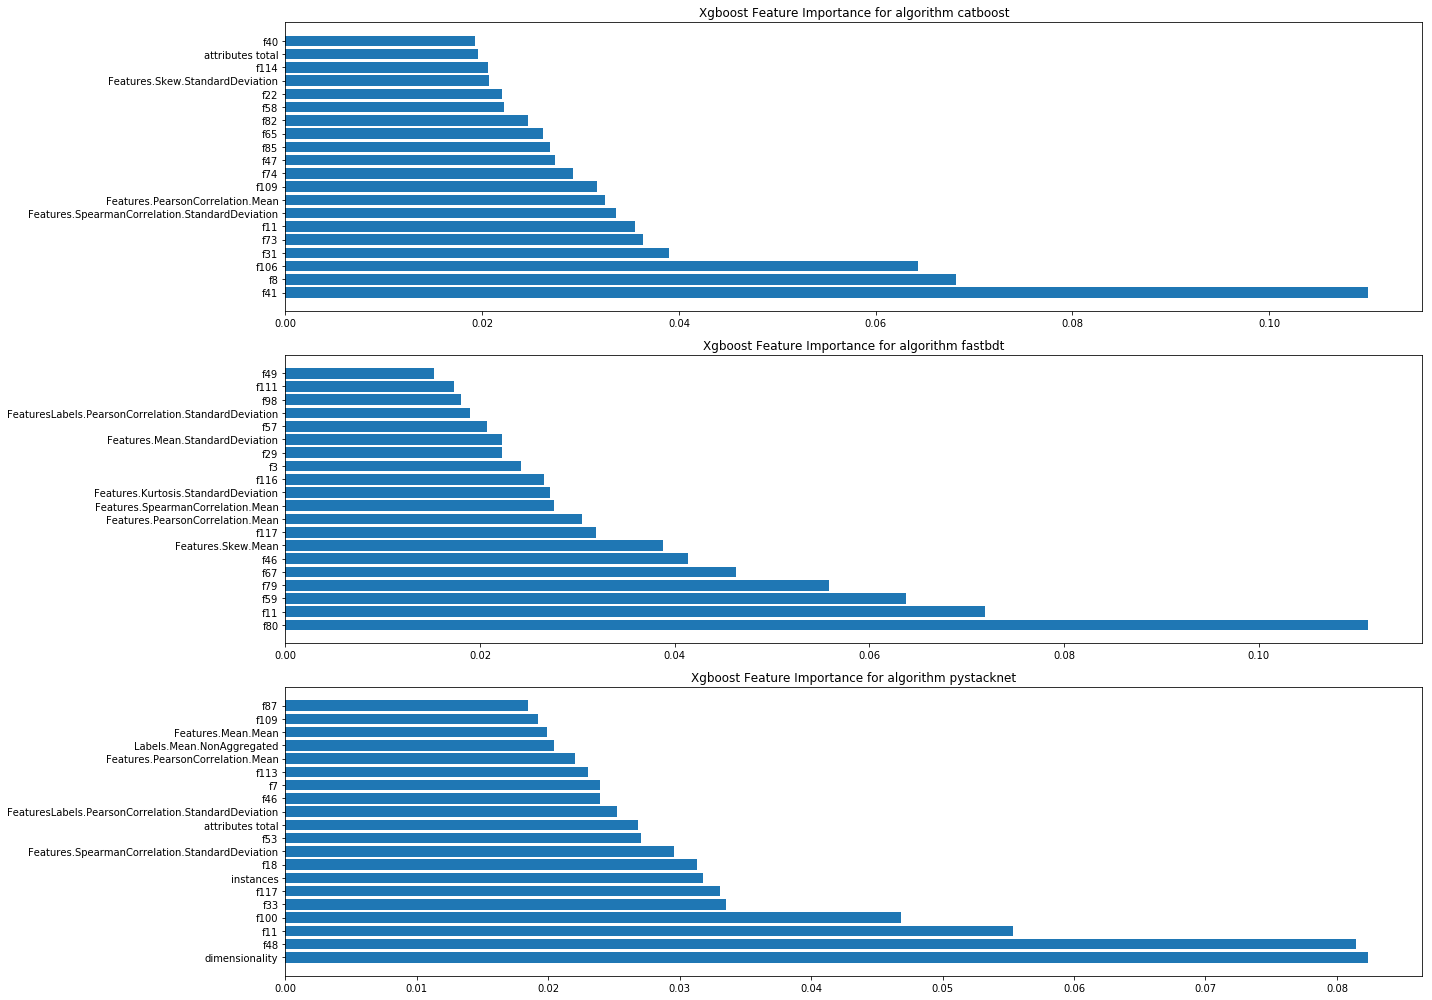

In [107]:
fig, axs = plt.subplots(len(classifiers),1, figsize=(20, 14), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 5, wspace=.001)
axs = axs.ravel()


for i,cls in enumerate(classifiers):
    print(algorithms[i])
    sorted_idx = np.flip(cls.feature_importances_.argsort())[:20]
    axs[i].barh([meta_cols[idx] for idx in sorted_idx], cls.feature_importances_[sorted_idx])
    axs[i].set_title("Xgboost Feature Importance for algorithm {A}".format(A=algorithms[i]))
plt.tight_layout()
plt.show()

catboost


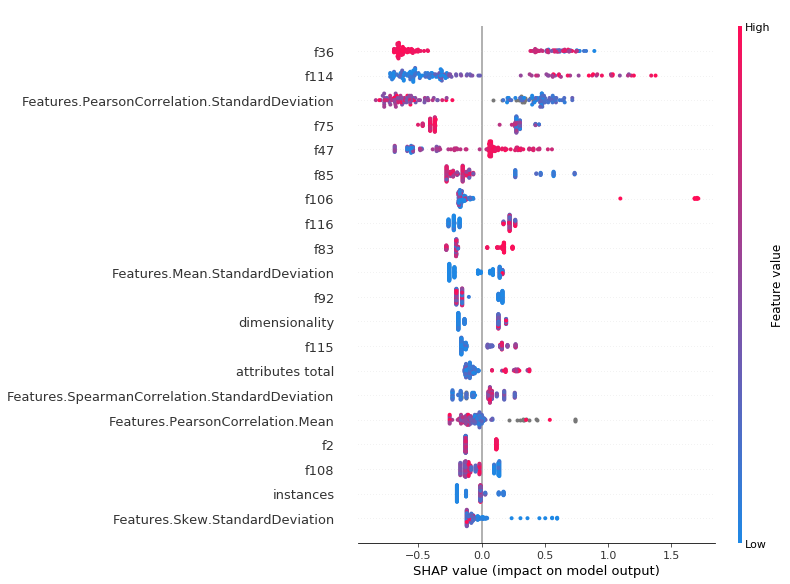

fastbdt


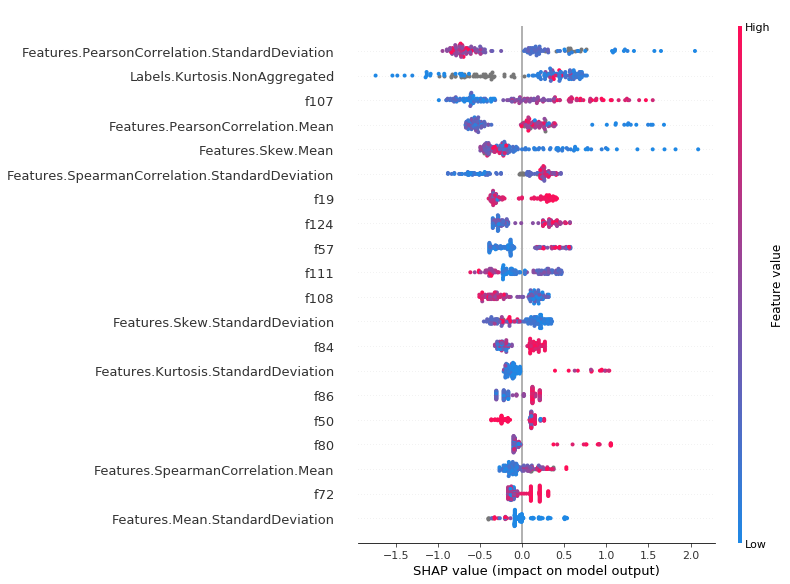

pystacknet


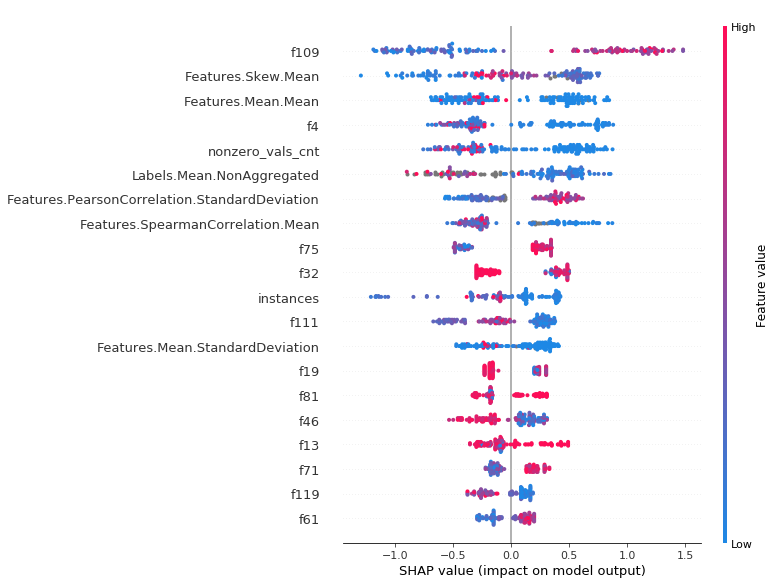

<Figure size 432x288 with 0 Axes>

In [110]:
import shap

# fig, axs = plt.subplots(len(classifiers),1, figsize=(20, 14), facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = 5, wspace=.001)
# axs = axs.ravel()


for i,cls in enumerate(classifiers):
    print(algorithms[i])
    explainer = shap.TreeExplainer(cls)
    shap_values = explainer.shap_values(meta_df[meta_cols])
    
    shap.summary_plot(shap_values, meta_df[meta_cols])

#     axs[i].barh([meta_cols[idx] for idx in sorted_idx], cls.feature_importances_[sorted_idx])
#     axs[i].set_title("Xgboost Feature Importance for algorithm {A}".format(A=algorithms[i]))

    
plt.tight_layout()
plt.show()
